In [1]:
##############################################################
# Libraries #

from dataloader import Bert4RecDataLoader, SASRecDataLoader
from models import build_model_bert4Rec

import pandas as pd
import numpy as np
import random
import pickle
import matplotlib.pyplot as plt

import os
from datetime import datetime, timedelta
import gc
from tqdm import tqdm
tqdm.pandas()
import time
import wandb

import tensorflow as tf
from tensorflow.keras import layers, losses, models, metrics, optimizers, constraints
from tensorflow.keras import mixed_precision
from tensorflow.keras.utils import Sequence
# from tensorflow_addons.optimizers import AdamW

physical_devices = tf.config.list_physical_devices('GPU')
print(physical_devices)
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    print('Invalid device or cannot modify virtual devices once initialized.')

##############################################################

2022-11-29 20:22:26.391031: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-29 20:22:26.458265: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-11-29 20:22:26.474335: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-29 20:22:26.793500: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: li

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2022-11-29 20:22:27.613015: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-29 20:22:27.626776: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-29 20:22:27.626871: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [2]:
##############################################################
# tfrecords for kaggle

# name_dataset = 'tfrecords_v0.4_kaggle'
# path_out = f'../tfrecords/{name_dataset}/'

# if not os.path.exists(path_out):
#     os.mkdir(path_out)

# for file in os.listdir(path_out + 'na_split_train'):
#     os.rename(path_out + 'na_split_train/' + file, 
#               path_out + 'na_split_train/' + file.replace('-', '_').replace('gz', 'tfrec'))

# for file in os.listdir(path_out + 'na_split_val'):
#     os.rename(path_out + 'na_split_val/' + file, 
#               path_out + 'na_split_val/' + file.replace('-', '_').replace('gz', 'tfrec'))

# for file in os.listdir(path_out + 'na_split_test'):
#     os.rename(path_out + 'na_split_test/' + file, 
#               path_out + 'na_split_test/' + file.replace('-', '_').replace('gz', 'tfrec'))

# for file in os.listdir(path_out + 'na_split_val_aug'):
#     os.rename(path_out + 'na_split_val_aug/' + file, 
#               path_out + 'na_split_val_aug/' + file.replace('-', '_').replace('gz', 'tfrec'))

# for file in os.listdir(path_out + 'na_split_test_aug'):
#     os.rename(path_out + 'na_split_test_aug/' + file, 
#               path_out + 'na_split_test_aug/' + file.replace('-', '_').replace('gz', 'tfrec'))


##############################################################

In [3]:
##############################################################
# Paths & Global Variables

# Train: (datetime.datetime(2022, 7, 31, 22, 0, 0, 25000), datetime.datetime(2022, 8, 28, 21, 59, 59, 984000))
# Test: (datetime.datetime(2022, 8, 28, 22, 0, 0, 278000), datetime.datetime(2022, 9, 4, 21, 59, 51, 563000))

path_data_raw = '../0_Data/'

AUTO = tf.data.AUTOTUNE

df_mapping = pd.read_csv('../tfrecords/tfrecords_v0.5/df_mapping.csv')
NUM_ITEMS = len(df_mapping['aid_map'].unique())
print(NUM_ITEMS)

dict_map = {}
for x in tqdm(df_mapping.to_dict('records')):
    dict_map[x['aid_map']] = x['aid']

dict_map_type = {
    'clicks' : 1,
    'carts' : 2,
    'orders' : 3
  }

##############################################################

1311743


100%|██████████| 1855603/1855603 [00:00<00:00, 8064294.05it/s]


In [4]:
list_paths = ['../tfrecords/tfrecords_v0.5/na_split=train/' + x for x in os.listdir('../tfrecords/tfrecords_v0.5/na_split=train')]
# 5,45, 1,09
dataloader = Bert4RecDataLoader(list_paths, 
                                num_items=NUM_ITEMS, 
                                seq_len=30, 
                                seq_len_target=None,
                                batch_size=32, 
                                mask_prob=0.4, 
                                reverse_prob=0.25, 
                                get_session=False,
                                is_val=False,
                                is_test=False,
                                shuffle=False).get_generator()
# Train
for batch in tqdm(dataloader):
    features, target = batch
    seq_items, seq_type, seq_time, seq_recency = features
    break

# # Test
# for batch in tqdm(dataloader):
#     features, target, session = batch
#     seq_items, seq_type, seq_time, seq_recency = features
#     idx_mask = target
#     break

# Val
# for batch in tqdm(dataloader):
#     features, targets, session = batch
#     seq_items, seq_type, seq_time, seq_recency = features
#     target, type_target, idx_mask = targets
#     break

print([x.shape for x in features])

idx = 11
print(seq_items[idx].numpy().flatten())
print(seq_type[idx].numpy().flatten())
print(target[idx].numpy().flatten())
# print(idx_mask[idx].numpy().flatten())
# print(type_target[idx].numpy().flatten())

del features, target, seq_items, seq_type, seq_time, seq_recency
gc.collect()

2022-11-29 20:22:32.467630: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-29 20:22:32.468339: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-29 20:22:32.468435: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-29 20:22:32.468474: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA

[TensorShape([32, 30, 1]), TensorShape([32, 30, 1]), TensorShape([32, 30, 8]), TensorShape([32, 30, 1])]
[      0 1044082  275523  586668  275523  164950       0 1240115  369673
       0   30011  280982  416175 1200323  732660  435547  914955       0
       0       0 1065462       0       0  650516       0 1284083  534990
       0 1149973 1252579]
[1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[ 813038       0       0       0       0       0  849746       0       0
  369673       0       0       0       0       0       0       0 1149973
  857961  591278       0  234511 1150803       0  389047       0       0
  337433       0       0]


0

In [5]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000, weight_decay=None):
        super(CustomSchedule, self).__init__()
        self.weight_decay = weight_decay
        self.weight_decay_tensor = tf.cast(1. if not weight_decay else weight_decay, tf.float32)
        self.d_model = tf.cast(d_model, tf.float32)
        self.warmup_steps = warmup_steps
    
    def get_config(self):
        config = {
          'd_model': self.d_model,
          'warmup_steps': self.warmup_steps,
        }
        return config

    def __call__(self, step):
        step = tf.cast(step, tf.float32)
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)
        if self.weight_decay:
            return self.weight_decay_tensor * tf.math.rsqrt(self.d_model) * tf.cast(tf.math.minimum(arg1, arg2), tf.float32)
        else:
            return tf.math.rsqrt(self.d_model) * tf.cast(tf.math.minimum(arg1, arg2), tf.float32)
    
    
class ReturnBestEarlyStopping(tf.keras.callbacks.EarlyStopping):
    def __init__(self, **kwargs):
        super(ReturnBestEarlyStopping, self).__init__(**kwargs)

    def on_train_end(self, logs=None):
        if self.stopped_epoch > 0:
            if self.verbose > 0:
                print(f'\nEpoch {self.stopped_epoch + 1}: early stopping')
        elif self.restore_best_weights:
            if self.verbose > 0:
                print('Restoring model weights from the end of the best epoch.')
            self.model.set_weights(self.best_weights)

# def custom_loss_bert4rec(tensor_weights=None):
#     # @tf.function(jit_compile=True)
#     def loss(y_true, y_pred):
#         mask = tf.where(y_true >= 1, 1., 0.)
#         loss = tf.nn.sparse_softmax_cross_entropy_with_logits(y_true, y_pred)
#         if tensor_weights is not None:
#             weights = tf.gather(params=tensor_weights, indices=y_true)
#             return tf.reduce_sum(loss * weights * mask) / (tf.reduce_sum(mask) + 1e-8)
#         else:
#             return tf.reduce_sum(loss * mask) / (tf.reduce_sum(mask) + 1e-8)
#     loss.__name__ = f'loss_bert4rec'
#     return loss

def weighted_loss_bert4rec(apply_weights=False):
    # @tf.function(jit_compile=True)
    def loss(y_true, y_pred, y_type):
        y_type = tf.squeeze(y_type, -1)
        mask = tf.where(y_true >= 1, 1., 0.)
        loss = tf.nn.sparse_softmax_cross_entropy_with_logits(y_true, y_pred)
        if apply_weights:
            w_clicks = tf.cast(y_type==1, tf.float32) * 0.1
            w_cart = tf.cast(y_type==2, tf.float32) * 0.3
            w_order = tf.cast(y_type==3, tf.float32) * 0.6
            weights = tf.reduce_max(tf.stack([w_clicks, w_cart, w_order], axis=-1), -1)
            return tf.reduce_sum(loss * mask * weights) / (tf.reduce_sum(mask * weights) + 1e-8)
        else:
            return tf.reduce_sum(loss * mask) / (tf.reduce_sum(mask) + 1e-8)
    loss.__name__ = f'weighted_loss_bert4rec'
    return loss
    

def custom_accuracy():
    def masked_accuracy(y_true, y_pred, y_type):
        y_pred = tf.argmax(y_pred, axis=2)
        y_true = tf.cast(y_true, y_pred.dtype)
        y_type = y_type[:, :, 0]
        mask_padding = y_true != 0
        mask_clicks = y_type == 1
        mask_carts = y_type == 2
        mask_orders = y_type == 3
        match = y_true == y_pred
        match_clicks = match & mask_padding & mask_clicks
        match_carts = match & mask_padding & mask_carts
        match_orders = match & mask_padding & mask_orders
        match_clicks, mask_clicks = tf.cast(match_clicks, dtype=tf.float32), tf.cast(mask_clicks, dtype=tf.float32)
        match_carts, mask_carts = tf.cast(match_carts, dtype=tf.float32), tf.cast(mask_carts, dtype=tf.float32)
        match_orders, mask_orders = tf.cast(match_orders, dtype=tf.float32), tf.cast(mask_orders, dtype=tf.float32)
        mask_padding = tf.cast(mask_padding, dtype=tf.float32)
        acc_clicks = tf.reduce_sum(match_clicks)/(tf.reduce_sum(mask_clicks * mask_padding)+1e-8)
        acc_carts = tf.reduce_sum(match_carts)/(tf.reduce_sum(mask_carts * mask_padding)+1e-8)
        acc_orders = tf.reduce_sum(match_orders)/(tf.reduce_sum(mask_orders * mask_padding)+1e-8)
        # score = 0.1*acc_clicks + 0.3*acc_carts + 0.6*acc_orders
        return acc_clicks, acc_carts, acc_orders
    masked_accuracy.__name__ = f'seq_acc'
    return masked_accuracy


def mrr_topk_categorical(top_k):
  """
  Mrr Topk Categorical metric
  """
  def mrr(y_true, y_pred):                                      
    n_samples = tf.shape(y_true)[0]
    n_samples_mask = tf.where(tf.reduce_sum(y_true, -1) >= 1, 1., 0.)
    _, top_index = tf.nn.top_k(y_pred, top_k)  
    result = tf.constant(0.0)
    top_index = tf.cast(top_index, tf.float32)
    idxs_not_masked = tf.cast(tf.argmax(y_true, axis=-1), tf.int32)
    for i in tf.range(n_samples):
        ranked_indicies = tf.where(tf.equal(top_index[i, idxs_not_masked[i], :], y_true[i, :][:, tf.newaxis]))
        if tf.shape(ranked_indicies)[0] > 0:
            ranked_indicies = tf.cast(ranked_indicies[0], tf.int32)
            #check that the prediction its not padding
            if top_index[i, ranked_indicies[0], ranked_indicies[1]] != 0.0: 
                rr = tf.cast(1/(ranked_indicies[1]+1), tf.float32)
            else:
                rr = tf.constant(0.0)
        else:
            rr = tf.constant(0.0)
        result+=rr
    return result/(tf.reduce_sum(n_samples_mask) + 1e-8)
  mrr.__name__ = f'mrr_{top_k}_categorical'
  return mrr


def recall_top_k(top_k=1, seq_len=10):
    # @tf.function
    def recall(y_true, y_pred):
        n_samples = tf.shape(y_pred)[0]
        y_true = tf.cast(y_true, tf.int64)
        mask = tf.cast(tf.math.logical_not(tf.math.equal(y_true, 0)), tf.int32)
        _, top_index = tf.nn.top_k(y_pred, top_k) 
        top_index = tf.cast(top_index, tf.int64)
        # cum_sum = tf.zeros(n_samples, tf.int32)
        result = tf.constant(0, tf.int32)
        for i in tf.range(seq_len):
            indexes_i = top_index[:, i, :]
            is_true = tf.reduce_sum(tf.reduce_max(tf.where(y_true[:, i:i+1]==indexes_i, 1, 0), -1) * mask[:, i])
            result += is_true
        return tf.cast(result, tf.float32) / (tf.cast(tf.reduce_sum(mask), tf.float32) + 1e-8)
    recall.__name__ = f'recall_{top_k}'
    return recall


def create_folder_with_version(base_name, checkpoint_path):
    if os.path.exists(os.path.join(checkpoint_path, base_name)):
        version_ = base_name.split('_v')
        if not version_ or len(version_)==1:
            base_name_no_version = base_name
            version_ = '_v1'
        else:
            base_name_no_version = '_'.join(base_name.split('_v')[:-1])
            version_ = f'_v{int(version_[-1])+1}'
        base_name = base_name_no_version + version_
        return create_folder_with_version(base_name, checkpoint_path)
    else:
        checkpoint_path = os.path.join(checkpoint_path, base_name)
        os.mkdir(checkpoint_path)
        return base_name

def set_seed(seed):
    tf.random.set_seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)

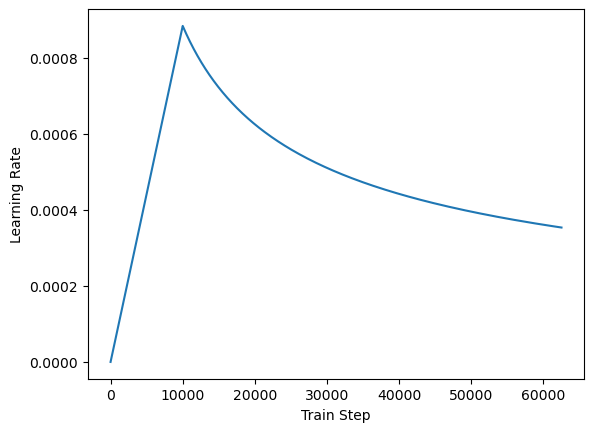

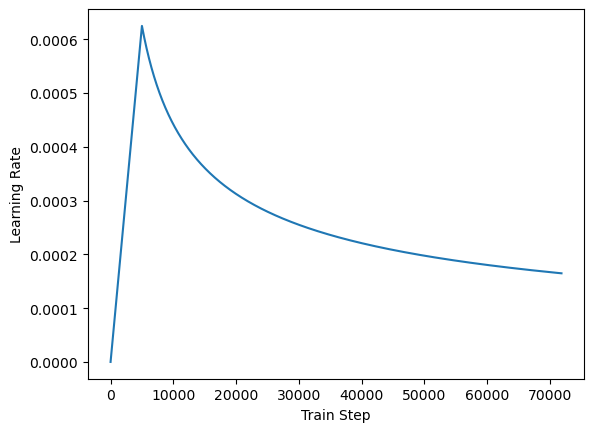

In [6]:
tmp_lr = CustomSchedule(128, 10_000, weight_decay=None)
finetune_lr = CustomSchedule(512, 5_000, weight_decay=None)
plt.plot(tmp_lr(tf.range(10_000_000 // (32* 5), dtype=tf.float32)))
plt.ylabel('Learning Rate')
plt.xlabel('Train Step')
plt.show();

plt.plot(finetune_lr(tf.range(2_300_000 // (32), dtype=tf.float32)))
plt.ylabel('Learning Rate')
plt.xlabel('Train Step')
plt.show();


In [7]:
####################################################

def flat_gradients(grads_or_idx_slices: tf.Tensor) -> tf.Tensor:
    '''Convert gradients if it's tf.IndexedSlices.
    When computing gradients for operation concerning `tf.gather`, the type of gradients 
    '''
    if type(grads_or_idx_slices) == tf.IndexedSlices:
        return tf.scatter_nd(
            tf.expand_dims(grads_or_idx_slices.indices, 1),
            grads_or_idx_slices.values,
            tf.cast(grads_or_idx_slices.dense_shape, tf.int64)
        )
    return grads_or_idx_slices

def backward_optimization(num_grad_steps, global_gradients, step_gradients, step, total_step, model, optimizer):
    if not global_gradients:
        global_gradients = step_gradients
    else:
        for i, g in enumerate(step_gradients):
            global_gradients[i] += flat_gradients(g)
    if (step + 1) % num_grad_steps == 0:
        optimizer.apply_gradients(zip(global_gradients, model.trainable_variables))
        global_gradients = []
        total_step += 1
    return global_gradients, total_step


@tf.function(jit_compile=True)
def train_step(*inputs, target, model, optimizer, num_accum_steps, **kwargs):
    l_loss, l_acc_clicks, l_acc_carts, l_acc_orders = kwargs['loss'], kwargs['acc_clicks'], kwargs['acc_carts'], kwargs['acc_orders']
    seq_type = kwargs['seq_type']
    with tf.GradientTape() as tape:
        predictions = model(*inputs, training=True)
        loss = loss_function(target, predictions, seq_type)
        acc_clicks, acc_carts, acc_orders = acc_function(target, predictions, seq_type)
        scaled_loss = optimizer.get_scaled_loss(loss) / num_accum_steps

    gradients = tape.gradient(scaled_loss, model.trainable_variables)
    gradients = optimizer.get_unscaled_gradients(gradients)
    # optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    l_loss(loss)
    l_acc_clicks(acc_clicks)
    l_acc_carts(acc_carts)
    l_acc_orders(acc_orders)
    return gradients
  
@tf.function
def test_step(*inputs, target, **kwargs):
    l_loss, l_acc_clicks, l_acc_carts, l_acc_orders = kwargs['loss'], kwargs['acc_clicks'], kwargs['acc_carts'], kwargs['acc_orders']
    seq_type = kwargs['seq_type']
    predictions = model(*inputs, training=False)
    loss = loss_function(target, predictions, seq_type)
    acc_clicks, acc_carts, acc_orders = acc_function(target, predictions, seq_type)
    l_loss(loss)
    l_acc_clicks(acc_clicks)
    l_acc_carts(acc_carts)
    l_acc_orders(acc_orders)
    return predictions


def metrics_reset_states(*metrics):
    for metric in metrics:
        metric.reset_states()


def fancy_printer(loss_tracker, epoch, batch_num, start, step='train', dict_metrics={}, num_epochs=1, **kwargs):
    num_step = kwargs['num_step']
    dict_print_metrics = {' '.join(f"{key}:{value:.6f}" for key, value in dict_metrics.items())}
    if step!='epoch':
        printer = f'[{step} Epoch]{epoch + 1}/{num_epochs} [Time]{time.time() - start:.2f} [Step]{num_step} [Batch]{batch_num} [Speed]{((time.time() - start)/max(1, batch_num))*1000:.2f}ms/step '
        printer += f'[Loss]{loss_tracker.result():.4f} ' + '[Metrics]' + str(dict_print_metrics)
        print(printer)
    else:
        train_loss, val_loss = kwargs['train_loss'], kwargs['val_loss']
        print(f'\nTime taken for epoch {epoch+1}/{num_epochs}: {time.time() - start:.2f} secs')
        printer = f'[Epoch]{epoch + 1}/{num_epochs} - [Train Loss]{train_loss.result():.4f} '
        printer += f'- [Val Loss]{val_loss.result():.4f} ' + str(dict_print_metrics)
        print(printer)


def log_wandb_metrics(step='train', num_step=0, dict_metrics=None, gradients=None, plot_image=False, **kwargs):
    # Scalar metrics
    if step=='train' or step=='val':
        wandb.log({name : value for name, value in dict_metrics.items()}, step=num_step)
    if step=='epoch':
        wandb.log({f'epoch_{name}' : value for name, value in dict_metrics.items()}, step=num_step)

    # Gradients
    if gradients:
        wandb.log({
            'mean_norm_gradients' : np.mean([tf.norm(x) for x in gradients]), 
            'max_norm_gradients': np.max([tf.norm(x) for x in gradients])
        })

def init_wandb(wandb_project='<your_project>', entity='', run_name='', dict_config=None):
    wandb.init(project=wandb_project, entity=entity, name=run_name, settings=wandb.Settings(code_dir="."),
               config=dict_config)
    wandb.run.log_code(".")


def grad_accum_scheduler(num_samples, list_scheduler, max_grad_accum):
    if num_samples >= len(list_scheduler):
        return max_grad_accum
    return list_scheduler[num_samples]

####################################################


In [8]:
####################################################
os.environ['WANDB_NOTEBOOK_NAME'] = '1_Model_v0.4.ipynb'

class BERT4REC_CONFIG:
    seed = 42 
    num_items = NUM_ITEMS
    model_arch = 'bert4rec'
    path_tfrecords = '../tfrecords/tfrecords_v0.5/'
    restore_last_chekpoint = (False, 'model_bert4rec_complete_0.11/checkpoints/', 'ckpt-27')
    model_name = f'model_{model_arch}_complete_0.11'
    checkpoint_filepath = f'../2_Models/'
    num_records_dataset = 10_000_000
    batch_size = 32
    tup_scheduler_grad_accum = (1, 5, 1_500_000) #(start_grad_accum, max_grad_accum, ramp_up_samples)
    seq_len = 20
    mask_prob = 0.3
    reverse_prob = 0.5
    emb_dim = 128
    trf_dim = 128
    num_heads = 4
    num_layers = 1
    ff_dim = trf_dim*4
    drop_rate = 0.1
    att_drop_rate = 0.1
    epochs = 3
    early_stopping = 5
    batch_num_printer_train = 500
    batch_num_printer_val = 250
    clipnorm = 1.0
    num_iters_save_checkpoint = 25_000
    scheduler_scaler = 128 
    warmup_steps = 10_000
    weight_decay = 1e-1
    log_wandb = True

set_seed(BERT4REC_CONFIG.seed)

list_scheduler = np.linspace(BERT4REC_CONFIG.tup_scheduler_grad_accum[0], 
                             BERT4REC_CONFIG.tup_scheduler_grad_accum[1], 
                             BERT4REC_CONFIG.tup_scheduler_grad_accum[2]).astype(np.uint8).tolist()

if BERT4REC_CONFIG.log_wandb:
    time_suffix = datetime.now().__str__().split('.')[0]
    dict_config = {k : v for k, v in zip(BERT4REC_CONFIG.__dict__.keys(), BERT4REC_CONFIG.__dict__.values()) if not k.startswith('__')}
    init_wandb(wandb_project='otto-recsys', entity='enric1296', run_name=f'{BERT4REC_CONFIG.model_name}_{time_suffix}', dict_config=dict_config)
    

list_paths_train = [f'{BERT4REC_CONFIG.path_tfrecords}na_split=train/' + x for x in os.listdir(f'{BERT4REC_CONFIG.path_tfrecords}na_split=train')] + \
                   [f'{BERT4REC_CONFIG.path_tfrecords}na_split=test_aug/' + x for x in os.listdir(f'{BERT4REC_CONFIG.path_tfrecords}na_split=test_aug')]
np.random.shuffle(list_paths_train)
list_paths_val = [f'{BERT4REC_CONFIG.path_tfrecords}na_split=val/' + x for x in os.listdir(f'{BERT4REC_CONFIG.path_tfrecords}na_split=val')]

train_dataloader = Bert4RecDataLoader(list_paths_train, 
                                     num_items=BERT4REC_CONFIG.num_items, 
                                     seq_len=BERT4REC_CONFIG.seq_len, 
                                     batch_size=BERT4REC_CONFIG.batch_size, 
                                     mask_prob=BERT4REC_CONFIG.mask_prob, 
                                     reverse_prob=BERT4REC_CONFIG.reverse_prob, 
                                     is_test=False,
                                     is_val=False,
                                     shuffle=True,
                                     drop_remainder=True).get_generator()

val_dataloader = Bert4RecDataLoader(list_paths_val, 
                                     num_items=BERT4REC_CONFIG.num_items, 
                                     seq_len=BERT4REC_CONFIG.seq_len,  
                                     batch_size=BERT4REC_CONFIG.batch_size, 
                                     mask_prob=0.0, 
                                     reverse_prob=0.0,  
                                     get_session=False,
                                     is_val=True,
                                     is_test=False,
                                     shuffle=False).get_generator()


tf.keras.backend.clear_session()

model = build_model_bert4Rec(num_items=BERT4REC_CONFIG.num_items, model_cfg=BERT4REC_CONFIG)
optimizer = optimizers.Adam(learning_rate=CustomSchedule(BERT4REC_CONFIG.scheduler_scaler, warmup_steps=BERT4REC_CONFIG.warmup_steps),
                            clipnorm=BERT4REC_CONFIG.clipnorm)
                            # weight_decay=BERT4REC_CONFIG.weight_decay)                  
optimizer = mixed_precision.LossScaleOptimizer(optimizer)                           
                            
# Build utils
ckpt = tf.train.Checkpoint(model=model, optimizer=optimizer)
if BERT4REC_CONFIG.restore_last_chekpoint[0]:
    checkpoint_path = os.path.join(BERT4REC_CONFIG.checkpoint_filepath, BERT4REC_CONFIG.restore_last_chekpoint[1])
    ckpt.restore(os.path.join(checkpoint_path, BERT4REC_CONFIG.restore_last_chekpoint[2]))
    print('Latest checkpoint restored!!')
    ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=10)
else:
    checkpoint_path = create_folder_with_version(BERT4REC_CONFIG.model_name, BERT4REC_CONFIG.checkpoint_filepath)
    ckpt_manager = tf.train.CheckpointManager(ckpt, os.path.join(BERT4REC_CONFIG.checkpoint_filepath, checkpoint_path, 'checkpoints'), 
                                            max_to_keep=10)

# Loss function
loss_function = weighted_loss_bert4rec(apply_weights=True)
acc_function = custom_accuracy()

# Trackers
train_loss = tf.keras.metrics.Mean(name='train_loss')
val_loss = tf.keras.metrics.Mean(name='val_loss')
train_acc_clicks = tf.keras.metrics.Mean(name='train_acc_clicks')
train_acc_carts = tf.keras.metrics.Mean(name='train_acc_carts')
train_acc_orders = tf.keras.metrics.Mean(name='train_acc_orders')
val_acc_clicks = tf.keras.metrics.Mean(name='val_acc_clicks')
val_acc_carts = tf.keras.metrics.Mean(name='val_acc_carts')
val_acc_orders = tf.keras.metrics.Mean(name='val_acc_orders')

##############################################

global_gradients = []
total_step, val_step, total_samples = 0, 0, 0
for epoch in range(BERT4REC_CONFIG.epochs):
    start = time.time()
    print('===='*20)
    print(f'Epoch {epoch + 1}')
    metrics_reset_states(train_loss, val_loss, train_acc_clicks, train_acc_carts, train_acc_orders, val_acc_clicks, val_acc_carts, val_acc_orders)
    
    for batch_num, batch_data in enumerate(train_dataloader):
        inputs, target = batch_data
        grad_accum = grad_accum_scheduler(total_samples,
                                          list_scheduler=list_scheduler, 
                                          max_grad_accum=BERT4REC_CONFIG.tup_scheduler_grad_accum[1])                                                             
        step_gradients = train_step(inputs, target=target, model=model, optimizer=optimizer, num_accum_steps=tf.constant(grad_accum, tf.float32), 
                                    loss=train_loss, acc_clicks=train_acc_clicks, acc_carts=train_acc_carts, acc_orders=train_acc_orders, seq_type=inputs[1])
        global_gradients, total_step = backward_optimization(grad_accum, global_gradients, step_gradients, batch_num, total_step, model, optimizer)
        if batch_num % BERT4REC_CONFIG.batch_num_printer_train == 0:
            train_dict_metrics = {x.name : x.result() for x in [train_loss, train_acc_clicks, train_acc_carts, train_acc_orders]}
            train_dict_metrics.update({'lr' : optimizer.lr(total_step).numpy().astype(np.float32), 'grad_accum' : grad_accum, 'total_samples' : total_samples})
            fancy_printer(train_loss, epoch, batch_num, start, step='Train', num_epochs=BERT4REC_CONFIG.epochs, dict_metrics=train_dict_metrics, num_step=total_step)
            if BERT4REC_CONFIG.log_wandb:
                train_dict_metrics.update({'step_grad' : total_step, 'step' : total_step})
                log_wandb_metrics(step='train', num_step=total_step, gradients=global_gradients, dict_metrics=train_dict_metrics)     
        total_samples += BERT4REC_CONFIG.batch_size * grad_accum if (batch_num+1) % grad_accum==0 else 0
        if batch_num % BERT4REC_CONFIG.num_iters_save_checkpoint==0:
            ckpt_save_path = ckpt_manager.save()
            print(f'Saving checkpoint for epoch {epoch+1} at step {total_step} on path {checkpoint_path}')
     
#     for val_batch_num, val_batch_data in enumerate(val_dataloader):
#         inputs, target = val_batch_data
#         predictions = test_step(inputs, target=target, loss=val_loss, acc_clicks=val_acc_clicks, acc_carts=val_acc_carts, acc_orders=val_acc_orders, seq_type=inputs[1])
#         val_step += 1
#         if val_batch_num % BERT4REC_CONFIG.batch_num_printer_val == 0:
#             val_dict_metrics = {x.name : x.result() for x in [val_loss, val_acc_clicks, val_acc_carts, val_acc_orders]}
#             fancy_printer(val_loss, epoch, val_batch_num, start, step='Val', num_epochs=BERT4REC_CONFIG.epochs, dict_metrics=val_dict_metrics, num_step=val_step)    
#             if BERT4REC_CONFIG.log_wandb:
#                 log_wandb_metrics(step='val', num_step=val_step, dict_metrics=val_dict_metrics) 
#                 # if val_batch_num==0:
#                 #     log_wandb_metrics(step=None, plot_image=True, 
#                 #                       model=model, inputs=inputs, epoch=epoch, target=target, stats=stats)
    
    ckpt_save_path = ckpt_manager.save()
    print(f'Saving checkpoint for epoch {epoch+1} at {checkpoint_path}')        
    
    epoch_dict_metrics = {x.name : x.result() for x in [train_loss, val_loss, train_acc_clicks, train_acc_carts, train_acc_orders]}
    printer = fancy_printer(None, epoch, epoch, start, step='epoch', num_step=epoch, dict_metrics=epoch_dict_metrics, 
                            train_loss=train_loss, val_loss=val_loss)
    if BERT4REC_CONFIG.log_wandb:
        log_wandb_metrics(step='epoch', num_step=total_step, dict_metrics=epoch_dict_metrics)

if BERT4REC_CONFIG.log_wandb:
    # wandb.save(checkpoint_path)
    wandb.finish()


####################################################

wandb: Currently logged in as: enric1296. Use `wandb login --relogin` to force relogin


INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3090 Ti, compute capability 8.6
Epoch 1


2022-11-29 20:23:12.838228: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
/home/enric/miniconda3/envs/py38_tensorflow/lib/python3.8/site-packages/tensorflow/python/framework/indexed_slices.py:436: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 167903104 elements. This may consume a large amount of memory.
  warnings.warn(
2022-11-29 20:23:13.922701: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x207b0a70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2022-11-29 20:23:13.922718: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce RTX 3090 Ti, Compute Capability 8.6
2022-11-29 20:23:13.946093: W tensorflow/compiler/tf2xla/kernels/random_ops.cc:57] Warning: Using tf.random.uniform with XLA compilation will ignore seeds; consid

[Train Epoch]1/3 [Time]2.95 [Step]1 [Batch]0 [Speed]2950.68ms/step [Loss]14.1943 [Metrics]{'train_loss:14.194280 train_acc_clicks:0.000000 train_acc_carts:0.000000 train_acc_orders:0.000000 lr:0.000000 grad_accum:1.000000 total_samples:0.000000'}
Saving checkpoint for epoch 1 at step 1 on path model_bert4rec_complete_0.11
[Train Epoch]1/3 [Time]44.04 [Step]501 [Batch]500 [Speed]88.09ms/step [Loss]14.1483 [Metrics]{'train_loss:14.148277 train_acc_clicks:0.000000 train_acc_carts:0.000000 train_acc_orders:0.000000 lr:0.000044 grad_accum:1.000000 total_samples:16000.000000'}
[Train Epoch]1/3 [Time]80.23 [Step]1001 [Batch]1000 [Speed]80.23ms/step [Loss]13.8731 [Metrics]{'train_loss:13.873052 train_acc_clicks:0.000044 train_acc_carts:0.000000 train_acc_orders:0.000000 lr:0.000088 grad_accum:1.000000 total_samples:32000.000000'}
[Train Epoch]1/3 [Time]116.15 [Step]1501 [Batch]1500 [Speed]77.43ms/step [Loss]13.6617 [Metrics]{'train_loss:13.661671 train_acc_clicks:0.000159 train_acc_carts:0.000

KeyboardInterrupt: 

# Validation

In [12]:
def get_score_metric(y_true, y_pred, type_target, k=20):
    score = 0 
    if len(y_true)==0:
        return None
    if type_target=='clicks':
        num_targets = 1
        hits = len([x for x in y_pred if x==y_true[0]])
    else:
        num_targets = min(k, len(y_true))
        hits = len([x for x in y_pred if x in y_true])
    score = hits / num_targets
    return score

tf.keras.backend.clear_session()
model = build_model_bert4Rec(num_items=BERT4REC_CONFIG.num_items, model_cfg=BERT4REC_CONFIG)
ckpt = tf.train.Checkpoint(model=model)
ckpt.restore(tf.train.latest_checkpoint(f'../2_Models/model_bert4rec_complete_0.11/checkpoints'))
list_paths_val = ['../tfrecords/tfrecords_v0.5/na_split=val/' + x for x in os.listdir('../tfrecords/tfrecords_v0.5/na_split=val')]
val_dataloader = Bert4RecDataLoader(list_paths_val, 
                                     num_items=NUM_ITEMS, 
                                     seq_len=20, 
                                     seq_len_target=20, 
                                     batch_size=32, 
                                     mask_prob=0.0, 
                                     reverse_prob=0.0, 
                                     is_val=True,
                                     get_session=True, 
                                     is_test=False,
                                     shuffle=False).get_generator()


list_sessions, list_past_items, list_predictions, list_trues, list_types = [], [], [], [], []
for num_batch, batch in enumerate(tqdm(val_dataloader)):
    features, targets, session = batch
    seq_items, seq_type, seq_time, seq_recency = features
    target, type_target, idx_mask = targets
    idxs = idx_mask.numpy() - 1 #tf.argmin(seq_items[:, :, 0], 1).numpy()
    for type_ in ['clicks', 'carts', 'orders']:
        seq_type_new = [tf.concat([
                        seq_type[i, :ix],
                        tf.constant([[dict_map_type[type_]]], tf.int64),
                        seq_type[i, ix+1:]], axis=0)
                    for i, ix in enumerate(idxs)]
        features = (seq_items, tf.stack(seq_type_new, axis=0), seq_time, seq_recency)
        preds = model(features, training=False)
        preds = tf.gather(preds, indices=idxs, axis=1, batch_dims=1)
        topk_scores, topk_idxs = tf.math.top_k(preds, k=20)
        topk_idxs = np.asarray([[dict_map[x] for x in topk_idxs.numpy()[i, :]] for i in range(topk_idxs.numpy().shape[0])])
        labels = [list(set([dict_map[_target] for _type, _target in zip(type_target.numpy()[i], target.numpy()[i]) if dict_map_type[type_]==_type and _target!=0])) for i in range(target.shape[0])]
        ###
        list_sessions.append(session.numpy())
        list_predictions.append(topk_idxs)
        list_types.append([type_ for _ in range(seq_items.shape[0])])
        list_trues = list_trues + labels
        list_past_items.append(seq_items.numpy()[:, :, 0])
    if num_batch==500:
        break

df_val = pd.DataFrame({
    'session' : np.concatenate(list_sessions),
    'past_items' : np.concatenate(list_past_items).tolist(),
    'predictions' : np.concatenate(list_predictions).tolist(),
    'trues' : list_trues,
    'type' : np.concatenate(list_types)
})
df_val['qt_trues'] = df_val['trues'].apply(lambda x : len(x))
df_val['score'] = df_val.progress_apply(lambda x: get_score_metric(x['trues'], x['predictions'], x['type']), axis=1)

display(df_val.describe())
dict_scores = df_val.groupby('type')['score'].mean().to_dict()
display(dict_scores)
kaggle_metric = 0.1*dict_scores['clicks'] + 0.3*dict_scores['carts'] + 0.6*dict_scores['orders']
print(f'Kaggle Metric: {kaggle_metric:.4f}')


# compare to
# (seq_len=20)model_bert4rec_complete_0.10 - ckpt28
# {'carts': 0.3811865255508249,
#  'clicks': 0.32103439425051333,
#  'orders': 0.5298270555929199}
# Kaggle Metric: 0.4644

# import wandb
# api = wandb.Api()
# run = api.run("<path to run>")
# run.summary["kaggle_metric"] = kaggle_metric
# run.update()

500it [00:45, 11.09it/s]
100%|██████████| 48096/48096 [00:00<00:00, 228775.81it/s]


,session,qt_trues,score
count,4.809600e+04,48096.000000,20109.000000
mean,6.409855e+06,1.399451,0.229244
std,3.715819e+06,2.914157,0.411915
min,9.630000e+02,0.000000,0.000000
25%,3.190015e+06,0.000000,0.000000
50%,6.383588e+06,0.000000,0.000000
75%,9.627672e+06,1.000000,0.000000
max,1.289967e+07,20.000000,1.000000


{'carts': 0.25834088232629765,
 'clicks': 0.21156314168377824,
 'orders': 0.36328300721079715}

Kaggle Metric: 0.3166


# Inference

In [ ]:
tf.keras.backend.clear_session()
model = build_model_bert4Rec(num_items=BERT4REC_CONFIG.num_items, model_cfg=BERT4REC_CONFIG)
ckpt = tf.train.Checkpoint(model=model)
ckpt.restore(tf.train.latest_checkpoint(f'../2_Models/model_bert4rec_complete_0.7/checkpoints'))


list_paths_test = ['../tfrecords/tfrecords_v0.5/na_split=test/' + x for x in os.listdir('../tfrecords/tfrecords_v0.5/na_split=test')]
test_dataloader = Bert4RecDataLoader(list_paths_test, 
                                     num_items=NUM_ITEMS, 
                                     seq_len=20,  
                                     batch_size=64, 
                                     mask_prob=0.0, 
                                     reverse_prob=0.0,  
                                     is_val=False,
                                     is_test=True,
                                     get_session=True,
                                     shuffle=False).get_generator()

list_predictions, list_sessions, list_types, list_scores = [], [], [], []
for num_batch, batch in enumerate(tqdm(test_dataloader)):
    features, idxs, session = batch
    seq_items, seq_type, seq_time, seq_recency = features
    idxs = idxs.numpy() - 1
    # idxs = tf.argmin(seq_items[:, :, 0], 1).numpy()
    ###
    for type_ in ['clicks', 'carts', 'orders']:
        seq_type_new = [tf.concat([
                        seq_type[i, :ix],
                        tf.constant([[dict_map_type[type_]]], tf.int64),
                        seq_type[i, ix+1:]], axis=0)
                    for i, ix in enumerate(idxs)]
        features = (seq_items, tf.stack(seq_type_new, axis=0), seq_time, seq_recency)
        preds = model(features, training=False)
        preds = tf.gather(preds, indices=idxs, axis=1, batch_dims=1)
        topk_scores, topk_idxs = tf.math.top_k(preds, k=20)
        topk_idxs = np.asarray([[dict_map[x] for x in topk_idxs.numpy()[i, :]] for i in range(topk_idxs.numpy().shape[0])])
        topk_idxs = topk_idxs - 1
        list_predictions.append(topk_idxs)
        list_types.append([type_ for _ in range(seq_items.shape[0])])
        list_sessions.append(session.numpy())
    # if num_batch==100:
    #     break
    

# 26122it [54:28,  7.99it/s]

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3090 Ti, compute capability 8.6


2022-11-20 19:15:23.433225: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
0it [00:00, ?it/s]2022-11-20 19:15:24.337587: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
26122it [55:08,  7.90it/s]


In [ ]:
name_submission = f"submission_{datetime.now().__str__().split('.')[0].replace(' ', '_').replace('-', '_').replace(':', '_')}"

df_inference = pd.DataFrame({
    'session' : np.concatenate(list_sessions),
    'predictions' : np.concatenate(list_predictions).tolist(),
    'type' : np.concatenate(list_types)
})

df_inference['session_type'] = df_inference['session'].astype(str) + '_' + df_inference['type']
df_inference['labels'] = df_inference['predictions'].apply(lambda x : ' '.join([str(y) for y in x]))
df_inference[['session_type', 'labels']].to_csv(f'../3_Submissions/{name_submission}.csv', index=False)

print(df_inference.shape)
display(
    df_inference
)

import gzip
with open(f'../3_Submissions/{name_submission}.csv', 'rb') as f_in, gzip.open(f'../3_Submissions/{name_submission}.csv.gz', 'wb') as f_out:
    f_out.writelines(f_in)